Generated synthetic dataset: rows = 2000
Feature columns: ['age', 'years_experience', 'num_skills', 'skill_match', 'assessments_score', 'certifications', 'networking_score', 'mentorship_sessions', 'job_search_intensity', 'platform_engagement', 'skill_density', 'skill_assess_interaction', 'net_engage_interaction', 'edu_highschool', 'edu_diploma', 'edu_bachelor', 'edu_master_phd', 'industry_code']

=== EDA SUMMARY ===
Rows: 2000
Career score summary:
 count    2000.000000
mean       97.594514
std         5.807215
min        62.733934
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: career_success_score, dtype: float64
Industry distribution:
 industry
tech       0.449
finance    0.206
health     0.196
retail     0.149
Name: proportion, dtype: float64


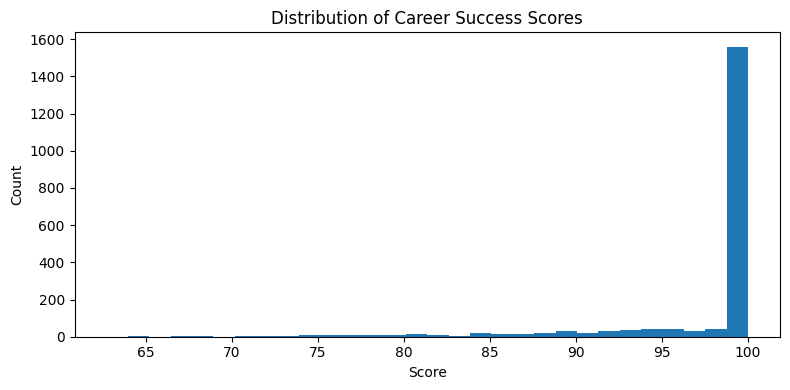

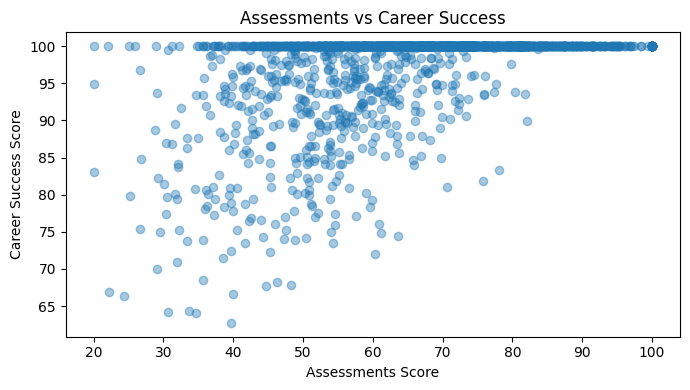

Train rows: 1600 Test rows: 400
RandomForest RMSE: 3.770  |  R^2: 0.579


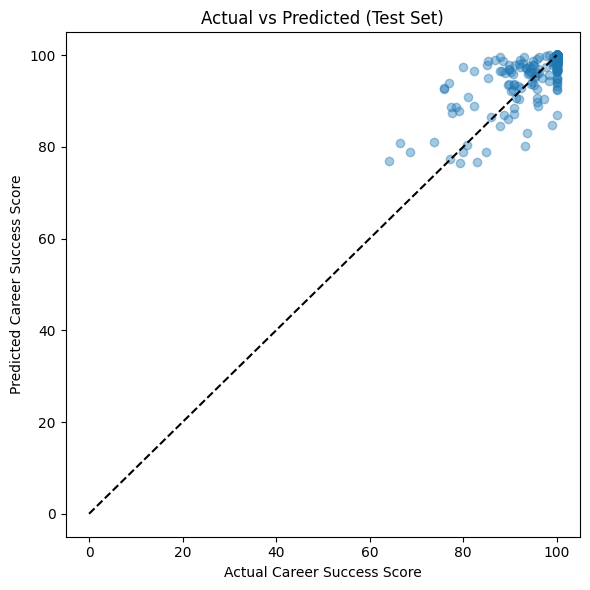

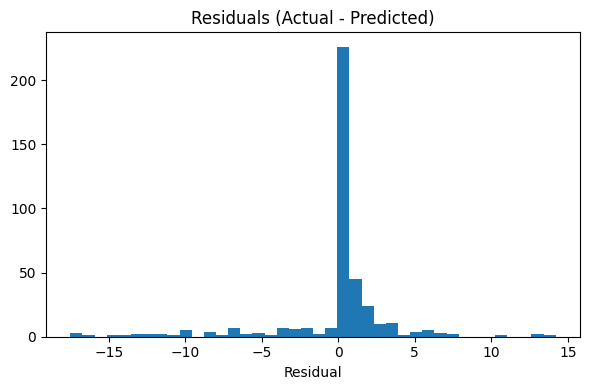

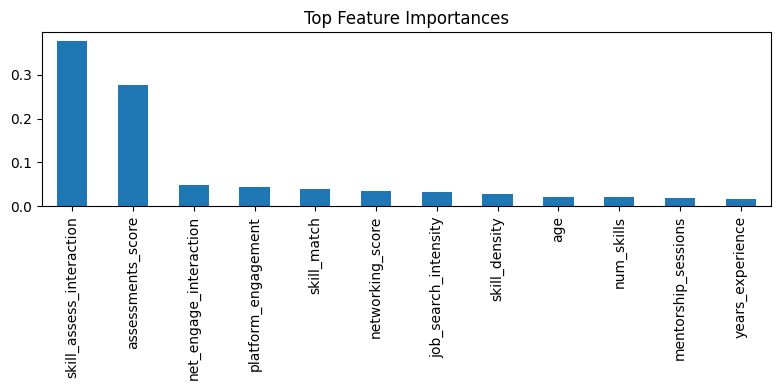

Top features:
 skill_assess_interaction    0.378
assessments_score           0.276
net_engage_interaction      0.048
platform_engagement         0.043
skill_match                 0.040
networking_score            0.034
job_search_intensity        0.032
skill_density               0.028
age                         0.022
num_skills                  0.020
dtype: float64
Artifacts saved to ./artifacts/


In [1]:
# src/career_coach.py
"""
치Personalized AI Career Coach (Meta-AI) - End-to-end example
- Generate synthetic candidate data
- Clean & feature-engineer
- EDA
- Train RandomForest regressor to predict career_success_score
- Evaluate with RMSE and R^2
- Visualize actual vs predicted, feature importances, residuals
"""

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# reproducibility
RSEED = 42
np.random.seed(RSEED)
random.seed(RSEED)

# ---------------------------
# 1) Generate synthetic dataset
# ---------------------------
def generate_synthetic_candidates(n=2000):
    """
    Produces a dataframe of candidate profiles with a numeric target `career_success_score` (0-100).
    Columns:
    - candidate_id, age, years_experience, education_level (0-3), num_skills,
      skill_match_score (0-1), assessments_score (0-100), certifications (count),
      networking_score (0-100), mentorship_sessions (per month), job_search_intensity (0-10),
      platform_engagement (0-100), industry (tech/finance/health/retail), target career_success_score
    """
    ages = np.random.randint(20, 60, size=n)
    years_exp = np.clip((ages - np.random.randint(18, 23, size=n)) + np.random.normal(0,2,size=n), 0, 40).astype(int)
    edu_levels = np.random.choice([0,1,2,3], size=n, p=[0.15,0.35,0.35,0.15])  # 0: High-school, 1: Diploma, 2: Bachelor, 3: Master/PhD
    num_skills = np.random.poisson(6, size=n) + 1
    skill_match = np.clip(np.random.beta(2,2,size=n), 0, 1)  # how many of target-role skills match
    assessments = np.clip(np.random.normal(65, 15, size=n), 20, 100) # online test scores
    certs = np.random.poisson(1.2, size=n)
    networking = np.clip(np.random.normal(55, 18, size=n), 0, 100)
    mentorship = np.random.poisson(0.6, size=n)
    job_search = np.random.randint(0,11, size=n)  # intensity 0-10
    platform_engagement = np.clip(np.random.normal(40, 22, size=n), 0, 100)
    industries = np.random.choice(['tech','finance','health','retail'], size=n, p=[0.45,0.2,0.2,0.15])

    rows = []
    for i in range(n):
        # base success driven by skills, assessments, experience, and networking
        base = 20
        base += 0.7 * assessments[i]  # assessments are highly predictive
        base += 0.8 * (skill_match[i]*100) * 0.5  # skill match important
        base += 0.3 * min(years_exp[i], 20)
        base += 0.4 * networking[i] * 0.2
        base += 1.5 * certs[i]
        base += 2.0 * mentorship[i]
        base += (edu_levels[i] * 3.0)

        # engagement & job_search increase chance in short-term
        base += 0.15 * platform_engagement[i]
        base += 0.5 * job_search[i]

        # industry bias (simulate market differences)
        industry_bias = {'tech': 2.5, 'finance': 1.0, 'health': 0.5, 'retail': -0.5}
        base += industry_bias[industries[i]]

        # add noise
        noise = np.random.normal(0, 7)
        score = base + noise

        # clamp 0-100
        score = float(np.clip(score, 0, 100))

        rows.append({
            'candidate_id': f'C{i:05d}',
            'age': ages[i],
            'years_experience': int(years_exp[i]),
            'education_level': int(edu_levels[i]),
            'num_skills': int(num_skills[i]),
            'skill_match': float(skill_match[i]),
            'assessments_score': float(assessments[i]),
            'certifications': int(certs[i]),
            'networking_score': float(networking[i]),
            'mentorship_sessions': int(mentorship[i]),
            'job_search_intensity': int(job_search[i]),
            'platform_engagement': float(platform_engagement[i]),
            'industry': industries[i],
            'career_success_score': score
        })

    df = pd.DataFrame(rows)
    return df

# generate and save a sample
os.makedirs('data', exist_ok=True)
df = generate_synthetic_candidates(n=2000)
df.to_csv('data/synthetic_candidates.csv', index=False)
print("Generated synthetic dataset: rows =", len(df))

# ---------------------------
# 2) Basic cleaning function
# ---------------------------
def clean_candidates(df):
    df = df.copy()
    # ensure datatypes
    for col in ['age','years_experience','education_level','num_skills','certifications','mentorship_sessions','job_search_intensity']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # numeric floats
    for col in ['skill_match','assessments_score','networking_score','platform_engagement','career_success_score']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())

    # fill industry
    if 'industry' in df.columns:
        df['industry'] = df['industry'].fillna('unknown')

    # cap unrealistic extremes
    df['career_success_score'] = df['career_success_score'].clip(0,100)

    return df

df = clean_candidates(df)

# ---------------------------
# 3) Feature engineering
# ---------------------------
def engineer_features(df):
    df = df.copy()

    # experience buckets
    df['exp_bucket'] = pd.cut(df['years_experience'], bins=[-1,0,2,5,10,20,50], labels=['0','1-2','3-5','6-10','11-20','20+'])
    # education one-hot
    df['edu_highschool'] = (df['education_level']==0).astype(int)
    df['edu_diploma'] = (df['education_level']==1).astype(int)
    df['edu_bachelor'] = (df['education_level']==2).astype(int)
    df['edu_master_phd'] = (df['education_level']==3).astype(int)

    # skill density: skills per year of experience (avoid divide-by-zero)
    df['skill_density'] = df['num_skills'] / (df['years_experience'].replace(0,1))

    # interaction features
    df['skill_assess_interaction'] = df['skill_match'] * (df['assessments_score']/100.0)
    df['net_engage_interaction'] = df['networking_score'] * (df['platform_engagement']/100.0)

    # encode industry as codes for tree-based model
    df['industry_code'] = df['industry'].astype('category').cat.codes

    # features list for modeling
    feature_cols = [
        'age','years_experience','num_skills','skill_match','assessments_score',
        'certifications','networking_score','mentorship_sessions','job_search_intensity',
        'platform_engagement','skill_density','skill_assess_interaction','net_engage_interaction',
        'edu_highschool','edu_diploma','edu_bachelor','edu_master_phd','industry_code'
    ]
    return df, feature_cols

df, FEATURE_COLS = engineer_features(df)
print("Feature columns:", FEATURE_COLS)

# ---------------------------
# 4) EDA (simple)
# ---------------------------
def simple_eda(df):
    print("\n=== EDA SUMMARY ===")
    print("Rows:", len(df))
    print("Career score summary:\n", df['career_success_score'].describe())
    print("Industry distribution:\n", df['industry'].value_counts(normalize=True).round(3))
    # quick plots
    plt.figure(figsize=(8,4))
    plt.hist(df['career_success_score'], bins=30)
    plt.title('Distribution of Career Success Scores')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # scatter: assessments vs score
    plt.figure(figsize=(7,4))
    plt.scatter(df['assessments_score'], df['career_success_score'], alpha=0.4)
    plt.xlabel('Assessments Score')
    plt.ylabel('Career Success Score')
    plt.title('Assessments vs Career Success')
    plt.tight_layout()
    plt.show()

simple_eda(df)

# ---------------------------
# 5) Modeling: train/test split
# ---------------------------
# Drop ID & target
X = df[FEATURE_COLS].copy()
y = df['career_success_score'].copy()

# train/test random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RSEED)

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])

# scale numeric features (good practice for some models)
NUMERIC = ['age','years_experience','num_skills','skill_match','assessments_score','certifications','networking_score','mentorship_sessions','job_search_intensity','platform_engagement','skill_density','skill_assess_interaction','net_engage_interaction']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[NUMERIC] = scaler.fit_transform(X_train[NUMERIC])
X_test_scaled[NUMERIC] = scaler.transform(X_test[NUMERIC])

# save scaler
os.makedirs('artifacts', exist_ok=True)
joblib.dump(scaler, 'artifacts/scaler_career_coach.joblib')

# ---------------------------
# 6) Train Random Forest regressor
# ---------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RSEED, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
joblib.dump(rf, 'artifacts/rf_career_coach.joblib')

# ---------------------------
# 7) Evaluate model
# ---------------------------
def evaluate_and_report(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return preds, rmse, r2

preds, rmse, r2 = evaluate_and_report(rf, X_test_scaled, y_test)
print(f"RandomForest RMSE: {rmse:.3f}  |  R^2: {r2:.3f}")

# save test results
results_df = X_test.copy().reset_index(drop=True)
results_df['actual_score'] = y_test.reset_index(drop=True)
results_df['predicted_score'] = preds
results_df.to_csv('artifacts/test_results_career_coach.csv', index=False)

# ---------------------------
# 8) Visualizations: actual vs predicted, residuals, feature importances
# ---------------------------
# scatter actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(results_df['actual_score'], results_df['predicted_score'], alpha=0.4)
plt.plot([0,100],[0,100], linestyle='--', color='k')  # perfect line
plt.xlabel('Actual Career Success Score')
plt.ylabel('Predicted Career Success Score')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()

# residuals
residuals = results_df['actual_score'] - results_df['predicted_score']
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
importances.head(12).plot(kind='bar')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

print("Top features:\n", importances.head(10).round(3))

print("Artifacts saved to ./artifacts/")
